In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.utils import resample
from bootstrapped import bootstrap as bs
from bootstrapped import stats_functions as bs_stats
from joblib import Parallel, delayed

In [2]:
# Load data
data = pd.read_csv("/Users/tspisak/data/PIC_conditioning_withinsub_nodatalad/signatures.csv")
studies = pd.read_csv("/Users/tspisak/data/PIC_conditioning_withinsub_nodatalad/palm/simple_zerocon/df_studies.csv")

# Exclude studies with insufficient data
exclude_studies = ["kessner", "ruetgen", "wager04a_princeton", "wager04b_michigan"]
studies = studies[~studies['study_ID'].isin(exclude_studies)]

data['plc_induction'] = data['Conditioning'].astype('category').cat.codes
data['Rating_diff'] = -1*data['Rating_diff']   # higher score stronger placebo
# center explanatory variables
data['Rating_pain_ctr'] = data['Rating_pain_ctr'] - data['Rating_pain_ctr'].mean()
data['Age'] = data['Age'] - data['Age'].mean()
data['Male'] = data['Male'] - data['Male'].mean()

# Display column names (optional)
# print(data.columns)
# print(studies.columns)

In [3]:
data

,Unnamed: 0,Study_ID,Sub_ID,Male,Age,NPS_pain_ctr,Rating_pain_ctr,Rating_diff,Conditioning,TR,...,fear_vicarious_pain_zhou_2020,negative_affect_common_ceko_2022,negative_affect_mechanical_ceko_2022,negative_affect_sound_ceko_2022,negative_affect_thermal_ceko_2022,negative_affect_visual_ceko_2022,vifs_fear_picture_zhou_2021,basic_sexual_image_vanthof_2021,brs_reward_monetary_speer_2022,plc_induction
0,0,atlas,atlas_remi1022s1,-0.169403,-1.635208,-14.056126,-5.653458,2.664155,suggestions,2000,...,0.016313,0.037931,0.001628,0.037247,0.001329,0.040771,0.047013,-0.040887,0.041096,0
1,1,atlas,atlas_remi1056s1,-0.169403,-1.635208,-17.798976,22.070501,20.196549,suggestions,2000,...,0.023691,-0.037930,-0.007684,-0.009602,-0.017617,-0.025331,0.037159,0.002307,-0.041179,0
2,2,atlas,atlas_remi1090s2,-0.169403,-1.635208,2.168433,37.675992,14.623164,suggestions,2000,...,0.072299,0.017802,-0.013074,-0.031132,0.043191,-0.007662,0.026102,0.008086,-0.067313,0
3,3,atlas,atlas_remi1126,-0.169403,-1.635208,7.489692,-9.352638,-11.918164,suggestions,2000,...,0.004046,-0.026222,0.012254,-0.004010,-0.019002,-0.028841,-0.052546,0.066338,0.019311,0
4,4,atlas,atlas_remi1262,-0.169403,-1.635208,0.628170,-10.284073,17.996207,suggestions,2000,...,-0.005427,-0.008387,0.037694,-0.020480,-0.021717,0.004830,0.029516,-0.001712,0.027564,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,404,zeidan,zeidan_088,0.354407,13.664792,-14181.082538,-4.676903,-2.000000,suggestions & conditioning,4000,...,-0.041332,0.004074,0.024568,0.007249,-0.026077,0.030768,0.019113,-0.046716,-0.058592,1
405,405,zeidan,zeidan_095,0.354407,1.664792,51758.838562,-12.676903,4.000000,suggestions & conditioning,4000,...,-0.019907,-0.012158,-0.017015,-0.053137,0.024225,-0.000572,0.006161,-0.015371,0.018483,1
406,406,zeidan,zeidan_097,-0.645593,-2.335208,77748.911669,-5.426903,-4.500000,suggestions & conditioning,4000,...,0.004466,-0.010598,-0.060007,-0.001854,0.039077,-0.034849,-0.009718,-0.009351,-0.007400,1
407,407,zeidan,zeidan_098,0.354407,9.664792,62130.045615,-30.676903,8.000000,suggestions & conditioning,4000,...,0.004821,0.021077,0.087820,-0.016302,-0.038430,0.041020,0.039214,-0.015043,-0.035104,1


/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_39148/1636943159.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.006896551724137931' has dtype incompatible with int8, please explicitly cast to a compatible dtype first.
  pheno.loc[pheno['plc_induction'] == 0, 'plc_induction'] = -1 / (pheno['plc_induction'] == 0).sum()
/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_39148/1636943159.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"]

plc_induction   -1.389815e-16
study_0         -8.686342e-18
study_5         -1.737268e-17
study_6         -3.474537e-17
study_12         5.211805e-17
study_13         0.000000e+00
study_1         -3.474537e-17
study_2          6.949073e-17
study_3          5.211805e-17
study_4          8.686342e-17
study_7          1.737268e-17
study_8          5.211805e-17
study_9          3.474537e-17
study_10        -6.080439e-17
study_11        -2.605902e-17
study_14         3.474537e-17
study_15         3.474537e-17
dtype: float64

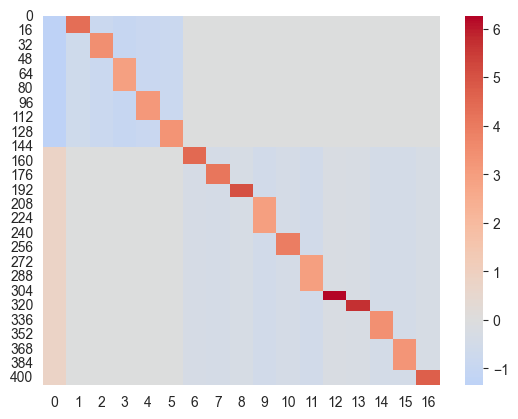

In [4]:
# create regression coded covariates for studies, being orthogonal to the "plc_induction" variable
# we do "simple coding", i.e. all regressors sum up to zero

def simple_coding(orig_pheno, sort=False):
    pheno = orig_pheno.copy()
    pheno['plc_induction'] = pheno['Conditioning'].astype('category').cat.codes
    # sort dataframe by induction type
    if sort:
        pheno = pheno.sort_values(by=['plc_induction', 'Study_ID'], inplace=False)

    # first we set 0 to -1 in induction type
    pheno.loc[pheno['plc_induction'] == 0, 'plc_induction'] = -1 / (pheno['plc_induction'] == 0).sum()
    pheno.loc[pheno['plc_induction'] == 1, 'plc_induction'] = 1 / (pheno['plc_induction'] == 1).sum()
    # model studies
    pheno['study'] = pheno['Study_ID'].astype('category').cat.codes
    # create simple coded variables
    colnames = []
    for i in pheno['study'].unique():
        colnames.append(f'study_{i}')
        pheno[f'study_{i}'] = 0
        # which induction type does this study belong to
        induction_type = pheno.loc[pheno['study'] == i, 'plc_induction'].unique()[0]
        # number of participants in the study
        n_instudy = pheno.loc[pheno['study'] == i].shape[0]
        # number of participants not in the study, but being in the same induction type
        n_notinstudy_ind = pheno.loc[(pheno['study'] != i) & (pheno['plc_induction'] == induction_type)].shape[0]
        pheno[f'study_{i}'].loc[pheno['plc_induction'] == induction_type] = -1 / n_notinstudy_ind
        pheno[f'study_{i}'].loc[pheno['study'] == i] = 1 / n_instudy
    return pheno, colnames


# plot the design matrix
design_sorted, colnames = simple_coding(data, sort=True)
design_sorted = design_sorted[['plc_induction'] + colnames]
design_sorted /= design_sorted.std()
sns.heatmap(design_sorted.to_numpy(), cmap='coolwarm', center=0)
# column means
design_sorted.mean()

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_39148/1636943159.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.006896551724137931' has dtype incompatible with int8, please explicitly cast to a compatible dtype first.
  pheno.loc[pheno['plc_induction'] == 0, 'plc_induction'] = -1 / (pheno['plc_induction'] == 0).sum()
/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_39148/1636943159.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"]

plc_induction   -4.343171e-17
study_0          0.000000e+00
study_1         -1.042361e-16
study_2          6.949073e-17
study_3          1.737268e-17
study_4          3.474537e-17
study_5         -1.042361e-16
study_6         -6.949073e-17
study_7         -3.474537e-17
study_8          6.949073e-17
study_9          3.474537e-17
study_10        -2.605902e-17
study_11        -1.737268e-17
study_12         3.474537e-17
study_13         0.000000e+00
study_14        -5.211805e-17
study_15         3.474537e-17
dtype: float64

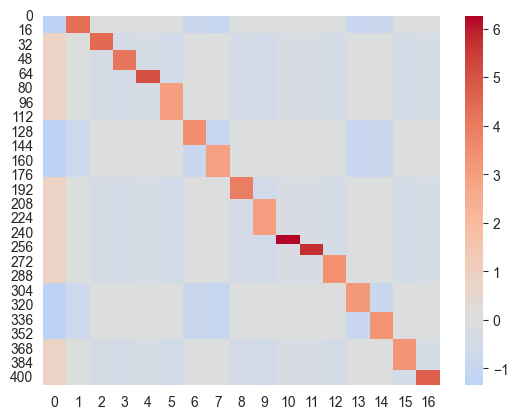

In [5]:
# The previous one was sorted for visualization purposes, here's the one to be used for the analyses
# plot the design matrix
design, colnames = simple_coding(data, sort=False)
design[['plc_induction'] + colnames] /= design[['plc_induction'] + colnames].std()
sns.heatmap(design[['plc_induction'] + colnames].to_numpy(), cmap='coolwarm', center=0)
# column means
design[['plc_induction'] + colnames].mean()

In [6]:
mean_inst = data[data['Conditioning'] == "suggestions"]['Rating_diff'].mean()
mean_cond = data[data['Conditioning'] == "suggestions & conditioning"]['Rating_diff'].mean()

print(f'Mean (INST): {mean_inst}')
print(f'Mean (COND-INST): {mean_cond}')
print(f'Difference: {mean_cond - mean_inst}')

Mean (INST): 9.17965372196802
Mean (COND-INST): 12.225893552576416
Difference: 3.046239830608396


In [8]:
import statsmodels.formula.api as smf
# Adding interaction term directly in the formula
formula = 'Rating_diff ~ plc_induction + Rating_pain_ctr + Age + Male' + ' + ' + ' + '.join(colnames)
print(formula)
# Fit linear model using formula API
model = smf.ols(formula=formula, data=design).fit()
print(model.summary())

print('One tailed p-value for plc_induction:', np.round(model.pvalues['plc_induction']/2, 3))

Rating_diff ~ plc_induction + Rating_pain_ctr + Age + Male + study_0 + study_1 + study_2 + study_3 + study_4 + study_5 + study_6 + study_7 + study_8 + study_9 + study_10 + study_11 + study_12 + study_13 + study_14 + study_15
                            OLS Regression Results                            
Dep. Variable:            Rating_diff   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     4.853
Date:                Wed, 31 Jul 2024   Prob (F-statistic):           7.29e-10
Time:                        10:58:50   Log-Likelihood:                -1695.8
No. Observations:                 409   AIC:                             3430.
Df Residuals:                     390   BIC:                             3506.
Df Model:                          18                                         
Covariance Type:            nonrobust                           

In [9]:
import statsmodels.formula.api as smf
# Adding interaction term directly in the formula
formula = 'Rating_diff ~ plc_induction * Rating_pain_ctr + Age + Male' + ' + ' + ' + '.join(colnames)
print(formula)
# Fit linear model using formula API
model = smf.ols(formula=formula, data=design).fit()
print(model.summary())

print('One tailed p-value for plc_induction:', np.round(model.pvalues['plc_induction']/2, 3))

Rating_diff ~ plc_induction * Rating_pain_ctr + Age + Male + study_0 + study_1 + study_2 + study_3 + study_4 + study_5 + study_6 + study_7 + study_8 + study_9 + study_10 + study_11 + study_12 + study_13 + study_14 + study_15
                            OLS Regression Results                            
Dep. Variable:            Rating_diff   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     4.751
Date:                Wed, 31 Jul 2024   Prob (F-statistic):           5.84e-10
Time:                        10:59:34   Log-Likelihood:                -1694.5
No. Observations:                 409   AIC:                             3429.
Df Residuals:                     389   BIC:                             3509.
Df Model:                          19                                         
Covariance Type:            nonrobust                           

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_41541/629020806.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='right', rotation_mode='anchor')


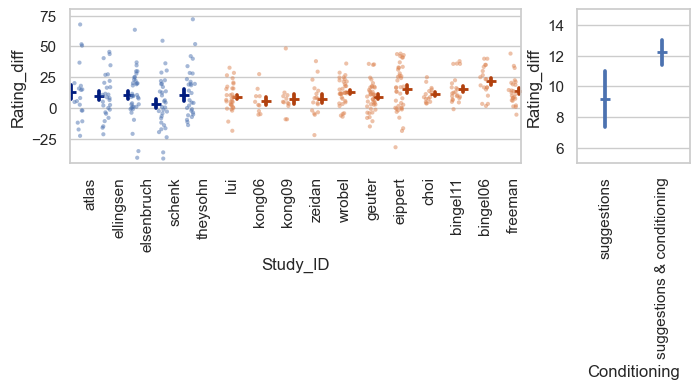

In [198]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(8, 2), gridspec_kw={'width_ratios': [4, 1]})
# Plot data with jitter and summary statistics
sns.stripplot(x='Study_ID', y='Rating_diff', hue='Conditioning', data=data.sort_values(by='Conditioning'), jitter=0.3, alpha=0.5, dodge=True, legend=False, ax=axes[0], size=3)
sns.pointplot(x='Study_ID', y='Rating_diff', hue='Conditioning', data=data.sort_values(by='Conditioning'), dodge=0.9, palette="dark", markers="_", errorbar="se", legend=False, linestyle='none', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, ha='right', rotation_mode='anchor')
axes[0].set_ylim(-45, 80)

#sns.violinplot(x='Conditioning', y='Rating_diff', data=data, inner='quartile', ax=axes[1])
#sns.boxplot(x='Conditioning', y='Rating_diff', data=data, ax=axes[1])
sns.pointplot(x='Conditioning', y='Rating_diff', data=data, markers="_", errorbar="se", linestyle='none', ax=axes[1])

plt.axhline(0, color='gray', linestyle='dashed', alpha=0.5)
plt.xticks(rotation=90)
plt.ylim(5, 15)
#plt.legend(title='Conditioning')
plt.savefig('../fig/behav_pointplot.pdf')
plt.show()

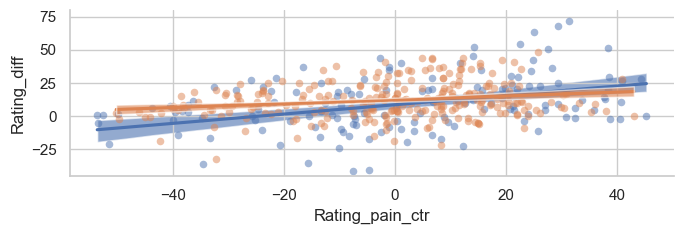

In [199]:
sns.set(style="whitegrid")

# Plot data with jitter and summary statistics
sns.lmplot(x='Rating_pain_ctr', y='Rating_diff', hue='Conditioning', data=data.sort_values(by='Conditioning'), 
           scatter_kws={'alpha':0.5, 's':30, 'linewidths': 0}, 
           line_kws={'alpha': 1},
           legend=False, height=2.5, aspect=2.8)
plt.setp(plt.gca().collections[1], alpha=0.6, zorder=-10)
plt.setp(plt.gca().collections[3], alpha=0.6, zorder=10)
plt.ylim(-45, 80)
plt.savefig('../fig/behav_interaction.pdf')

In [11]:
(1-0.048)/2

0.476

In [12]:
0.243/2

0.1215

In [17]:
model = smf.ols(formula='Rating_diff ~ plc_induction + Rating_pain_ctr + Age + Male' + ' + ' + ' + '.join(colnames),
                data=design).fit()

model_restricted = smf.ols(formula='Rating_diff ~ plc_induction + Rating_pain_ctr + Age + Male',
                data=design).fit()

f, p, df = model.compare_f_test(model_restricted)
print(f'F-statistic: {f}, p-value: {p}, df: {df}')

F-statistic: 2.4368272671859095, p-value: 0.0026929251450258924, df: 14.0
